Code by Jonas

In [4]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [5]:
def RandomForest(X_train,y_train, X_test, y_test, trees):
    seed = 42
    rf_result = []
    rf_results = {}
    for n_estimator in trees:
        rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
        rf_model.fit(X_train, y_train)
        rf_y_pred = rf_model.predict(X_test)
        mse = metrics.mean_squared_error(y_test, rf_y_pred)
        rf_result.append(mse)
        rf_results[n_estimator] = mse
        return pd.DataFrame(rf_results)

In [6]:
#read in the data
path_bindingAffinity = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/binding_affinity/binding_info.csv'
df_bindingAffinity = pd.read_csv(path_bindingAffinity)

pathShannon = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/manual/Shannon.csv'
df_Shannon = pd.read_csv(pathShannon)
pathAllel = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/alleles.csv'
df_allel = pd.read_csv(pathAllel)

pathPeptide = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/peptides.csv'
df_peptide = pd.read_csv(pathPeptide)

pathrank = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/rank_EL_matrix.csv'
df_rank = pd.read_csv(pathrank, header=None)
df_rank.columns = df_allel['allele'].values

df_rank.index = df_peptide['peptide'].values

pathscore = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/NetMHCpan/score_EL_matrix.csv'
df_score = pd.read_csv(pathscore, header=None)
df_score.columns = df_allel['allele'].values
df_score.index = df_peptide['peptide'].values

pathKl = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/HIV_db/before_filtering/Entropy_One/entropy.csv'
df_Kl = pd.read_csv(pathKl)

pathKlFilt = '/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/entropy/HIV_db/after_filtering/Entropy-One/entropy.csv'
df_KlFilt = pd.read_csv(pathKlFilt)


savePath = "/Users/jones/coding/Princeton_Homework/QCB455_Comp/project/551-project-main/data/regression"

In [7]:
#flip the rank matrix -> higher MHC binding between peptide and allele leads to higher score
dfAnalysis = df_rank.copy()
maxVal= dfAnalysis.max().max()
minVal = dfAnalysis.min().min()
dfAnalysisNew = maxVal + minVal - dfAnalysis


In [8]:
#calculate the weighted sum 
#using maximum of the allele frequency
allelScore = df_allel.iloc[:, -6:-1].max(axis=1)
dfSum = dfAnalysisNew
dfSum.columns = allelScore
dfSum.index = df_peptide['freq']
weighted_rowSum = (dfSum * dfSum.index.values.reshape(-1, 1) * dfSum.columns.values).sum(axis=1)

weighted_rowSum.index = (df_peptide['pos'] +1)
weighted_rowSum = weighted_rowSum.groupby(weighted_rowSum.index).sum()

In [9]:
# rename KL divergence df to match column name in Shannon entropy df
df_Kl.rename(columns={'Position': 'pos'}, inplace=True)

In [10]:
#extract for each peptide the position with the highest KL divergence and highest binding affinity

maxEntropyList = []
maxBindingAffinityList = []



for i in range(len(weighted_rowSum)):
    start = i
    end = start +9
    df_help = df_Kl[df_Kl['pos'].isin(np.arange(start, end))]
    maxEntValue = df_help['Entropy'].max()
    bindingMax = df_bindingAffinity.loc[df_bindingAffinity['seq_position'].isin(df_help[df_help['Entropy'] == maxEntValue]['pos'].values)]['value'].max()
    maxBindingAffinityList.append(bindingMax)
    maxEntropyList.append(maxEntValue)

dfMaxEntropy = pd.DataFrame({'pos': np.arange(1, 1266), 'EntropyMax':  maxEntropyList, 'maxBinding': maxBindingAffinityList})

In [11]:
#Create X & Y variables for linear regression
Y = dfMaxEntropy['EntropyMax'].values
X = np.column_stack((weighted_rowSum.values, dfMaxEntropy['maxBinding'].values))

In [13]:
#random forest simulations

trees = np.arange(1, 1000, 1)

seed = 42
rf_result = []
rf_results = {}
for n_estimator in trees:
    rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
    rf_model.fit(X, Y)
    rf_y_pred = rf_model.predict(X)
    mse = metrics.mean_squared_error(Y, rf_y_pred)
    rf_results[n_estimator] = mse

In [14]:
# predict on number of estimators with the lowest test mean squared error

min_key = min(rf_results, key=rf_results.get)
n_estimator = min_key 

rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
rf_model.fit(X, Y)
rf_y_pred = rf_model.predict(X)

Text(0, 0.5, 'KL divergence predicted')

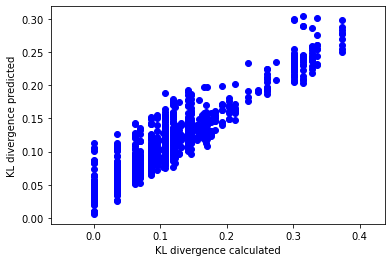

In [16]:
plt.scatter(Y, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Train-test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=59)

In [18]:
#random forest regression
seed = 42
trees = np.arange(1, 1000, 1)
rf_result = []
rf_results = {}
for n_estimator in trees:
    rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, rf_y_pred)
    rf_results[n_estimator] = mse

In [19]:
# predict on number of estimators with the lowest test mean squared error
min_key = min(rf_results, key=rf_results.get)
n_estimator = min_key 

rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
rf_model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=38, random_state=42)

Text(0, 0.5, 'KL divergence predicted')

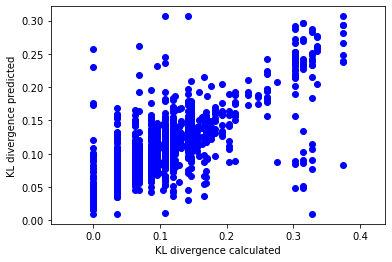

In [20]:
#prediction on full data
rf_y_pred = rf_model.predict(X)
plt.scatter(Y, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Text(0, 0.5, 'KL divergence predicted')

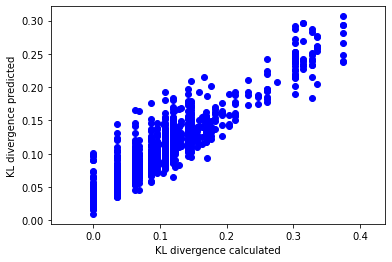

In [21]:
#accuracy training data
rf_y_pred = rf_model.predict(X_train)
plt.scatter(y_train, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Text(0, 0.5, 'KL divergence predicted')

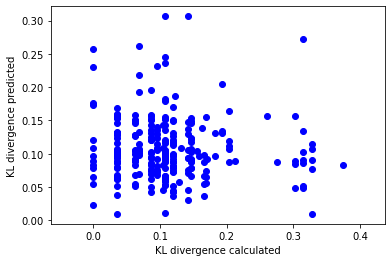

In [22]:
#accuracy test data
rf_y_pred = rf_model.predict(X_test)
plt.scatter(y_test, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

In [23]:
#correlation coefficient between prediction and real value of test data
correlation_coefficient = np.corrcoef(y_test, rf_y_pred)[0, 1]
print("Correlation Coefficient of test data between prediction and calculated KL divergence:", correlation_coefficient)

Correlation Coefficient of test data between prediction and calculated KL divergence: -0.07320751676423089


Shannon entropy

In [24]:
dfSum = dfAnalysisNew
dfSum.columns = allelScore
dfSum = dfAnalysisNew
dfSum.columns = allelScore
dfSum.index = df_peptide['freq']
weighted_rowSum = (dfSum * dfSum.index.values.reshape(-1, 1) * dfSum.columns.values).sum(axis=1)

weighted_rowSum.index = (df_peptide['pos'] +1)
weighted_rowSum = weighted_rowSum.groupby(weighted_rowSum.index).sum()

In [25]:
#extract for each peptide the position with the highest Shannon entropy and highest binding affinity

maxEntropyList = []
maxBindingAffinityList = []

for i in range(len(weighted_rowSum)):
    start = i
    end = start +9
    df_help = df_Shannon[df_Shannon['pos'].isin(np.arange(start, end))]
    maxEntValue = df_help['Shannon'].max()
    bindingMax = df_bindingAffinity.loc[df_bindingAffinity['seq_position'].isin(df_help[df_help['Shannon'] == maxEntValue]['pos'].values)]['value'].max()
    maxBindingAffinityList.append(bindingMax)
    maxEntropyList.append(maxEntValue)

dfMaxEntropy = pd.DataFrame({'pos': np.arange(1, 1266), 'EntropyMax':  maxEntropyList, 'maxBinding': maxBindingAffinityList})

In [26]:
#define Y,X, train and test data
Y = dfMaxEntropy['EntropyMax'].values
X = np.column_stack((weighted_rowSum.values, dfMaxEntropy['maxBinding'].values))

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=59)

In [27]:
#random forest simulations
seed = 42
trees = np.arange(1, 1000, 1)
rf_result = []
rf_results = {}
for n_estimator in trees:
    rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
    rf_model.fit(X_train, y_train)
    rf_y_pred = rf_model.predict(X_test)
    mse = metrics.mean_squared_error(y_test, rf_y_pred)
    rf_results[n_estimator] = mse

In [28]:
# predict on number of estimators with the lowest test mean squared error
min_key = min(rf_results, key=rf_results.get)
n_estimator = 10
rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

Text(0, 0.5, 'KL divergence predicted')

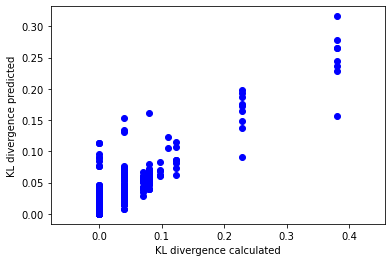

In [29]:
#accuracy training
rf_y_pred = rf_model.predict(X_train)
plt.scatter(y_train, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Text(0, 0.5, 'KL divergence predicted')

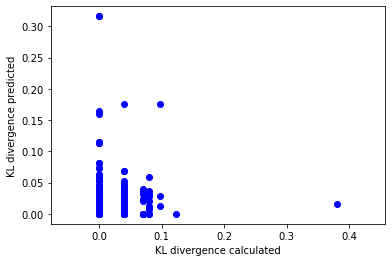

In [30]:
#accuracy test data
rf_y_pred = rf_model.predict(X_test)
plt.scatter(y_test, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

In [31]:
correlation_coefficient = np.corrcoef(y_test, rf_y_pred)[0, 1]
print("Correlation Coefficient of test data between prediction and calculated Shannon entropy:", correlation_coefficient)

Correlation Coefficient of test data between prediction and calculated Shannon entropy: -0.05761788119456317


Handling imbalanced dataset

In [89]:
#shannonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] <= 0.04004863]
#shannonNonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] > 0.04004863]
shannonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] == 0]
shannonNonZero = dfMaxEntropy.loc[dfMaxEntropy['EntropyMax'] > 0]

In [90]:
#use 80% of non-zero values and the same amount of zero values to train regression model

randomNonZero = np.random.choice(shannonNonZero['pos'].values, int(len(shannonNonZero)*0.8), replace=False)
shannonNonZeroRandom = shannonNonZero.loc[shannonNonZero['pos'].isin(randomNonZero)]
weighted_rowSum_NonZeroRandom = weighted_rowSum[weighted_rowSum.index.isin(randomNonZero)]

randomZeroShannon = np.random.choice(shannonZero['pos'].values, int(len(shannonNonZero)*0.8), replace=False)
shannonZeroRandom = shannonZero.loc[shannonZero['pos'].isin(randomZeroShannon)]
weighted_rowSum_ZeroRandom = weighted_rowSum[weighted_rowSum.index.isin(randomZeroShannon)]

In [91]:
#define train and test data

Y_train = np.append(shannonNonZeroRandom['EntropyMax'].values, shannonZeroRandom['EntropyMax'].values)
X_train = np.column_stack((np.append(weighted_rowSum_NonZeroRandom.values,weighted_rowSum_ZeroRandom.values) , 
                           np.append(shannonNonZeroRandom['maxBinding'].values, shannonZeroRandom['maxBinding'].values )))

trainingPos = np.append(randomNonZero,randomZeroShannon)

weighted_rowSum_test = weighted_rowSum[~weighted_rowSum.index.isin(trainingPos)]
shannonTest = dfMaxEntropy.loc[~dfMaxEntropy['pos'].isin(trainingPos)]


Y_test = shannonTest['EntropyMax'].values
X_test = np.column_stack((weighted_rowSum_test.values , shannonTest['maxBinding'].values))

In [92]:
#random forest regression
seed = 42
trees = np.arange(1, 1000, 10)
rf_result = []
rf_results = {}
for n_estimator in trees:
    rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
    rf_model.fit(X_train, Y_train)
    rf_y_pred = rf_model.predict(X_test)
    mse = metrics.mean_squared_error(Y_test, rf_y_pred)
    rf_results[n_estimator] = mse

In [93]:
# predict on number of estimators with the lowest test mean squared error
min_key = min(rf_results, key=rf_results.get)
n_estimator = min_key 
rf_model = RandomForestRegressor(n_estimators=n_estimator, random_state=seed)
rf_model.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=571, random_state=42)

Text(0, 0.5, 'KL divergence predicted')

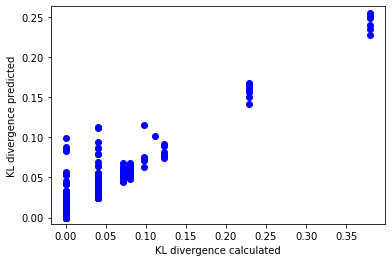

In [94]:
#accuracy training
rf_y_pred = rf_model.predict(X_train)
plt.scatter(Y_train, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

Text(0, 0.5, 'KL divergence predicted')

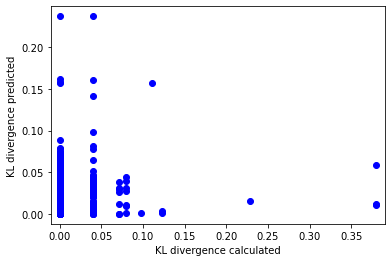

In [95]:
#test accuracy
rf_y_pred = rf_model.predict(X_test)
plt.scatter(Y_test, rf_y_pred, color='blue', marker='o')
plt.axis('equal')
plt.xlabel('KL divergence calculated')
plt.ylabel('KL divergence predicted')

In [96]:
correlation_coefficient = np.corrcoef(Y_test, rf_y_pred)[0, 1]
print("Correlation Coefficient of test data between prediction and calculated Shannon entropy:", correlation_coefficient)

Correlation Coefficient of test data between prediction and calculated Shannon entropy: -0.0012637539520523333


In [51]:
min_key

291